# Quick Start with AAanalysis
**AAanalysis** is a Python framework for sequence-based protein prediction, centered around the ``CPP`` model for interpretable feature engineering.

First, import some third-party packages and ``aanalsis``:

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import aaanalysis as aa
aa.options["verbose"] = False

We can load a dataset of amino acid scales and an example dataset for γ-secretase of 50 substrates and 50 non-substrates:

In [20]:
df_scales = aa.load_scales()
df_seq = aa.load_dataset(name="DOM_GSEC", n=50)

Starting the **Feature Engineering**, we first utilize the  ``AAclust`` model for pre-selecting a redundancy-reduced set of amino acid scales:

In [21]:
aac = aa.AAclust()
X = np.array(df_scales).T
scales = aac.fit(X, names=list(df_scales), n_clusters=100).medoid_names_ 
df_scales = df_scales[scales]

We can now use the *Comparative Physical Profiling (CPP)* algorithm, which aims at identifying a set of features most discriminant between two sets of sequences. Its core idea is the CPP feature concept, defined as a combination of *Parts*, *Splits*, and *Scales*. Parts and Splits can be obtained using ``SequenceFeature``:

In [22]:
sf = aa.SequenceFeature()
df_parts = sf.get_df_parts(df_seq=df_seq, list_parts=["tmd"])
split_kws = sf.get_split_kws(n_split_max=1, split_types=["Segment"])

Running the CPP algorithm creates all `Part-Split-Split` combinations and filters a selected maximum of non-redundant features. As a baseline approach,
we use CPP without filtering (`max_cor=1`) to compute the average values for the 100 selected scales over the entire TMD sequences:

In [23]:
# Small set of CPP features (100 features are created)
y = list(df_seq["label"])
cpp = aa.CPP(df_scales=df_scales, df_parts=df_parts, split_kws=split_kws)
df_feat = cpp.run(labels=y, max_cor=1)
aa.display_df(df=df_feat.head(10))

,feature,category,subcategory,scale_name,scale_description,abs_auc,abs_mean_dif,mean_dif,std_test,std_ref,p_val_mann_whitney,p_val_fdr_bh,positions
1,"TMD-Segment(1,1)-WOLR790101",Polarity,Hydrophobicity (surrounding),Hydration potential,"Hydrophobicity index (Wolfenden et al., 1979)",0.246000,0.032767,0.032767,0.028962,0.037213,0.000022,0.002203,"11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30"
2,"TMD-Segment(1,1)-FAUJ880109",Energy,Isoelectric point,Number hydrogen bond donors,"Number of hydrogen bond donors (Fauchere et al., 1988)",0.222000,0.020946,-0.020946,0.020626,0.026994,0.000110,0.005485,"11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30"
3,"TMD-Segment(1,1)-CHOC760103",ASA/Volume,Buried,Buried,"Proportion of residues 95% buried (Chothia, 1976)",0.218000,0.040137,0.040137,0.044550,0.055506,0.000174,0.005728,"11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30"
4,"TMD-Segment(1,1)-PRAM900101",Polarity,Hydrophilicity,Polarity (hydrophilicity),"Hydrophobicity (Prabhakaran, 1990)",0.209000,0.017235,-0.017235,0.016659,0.025221,0.000312,0.005728,"11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30"
5,"TMD-Segment(1,1)-YUTK870104",Energy,Free energy (unfolding),Free energy (unfolding),"Activation Gibbs energy of unfolding, pH9.0 (Yutani et al., 1987)",0.209000,0.007919,0.007919,0.011043,0.016763,0.000311,0.005728,"11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30"
6,"TMD-Segment(1,1)-FUKS010106",Composition,Membrane proteins (MPs),Proteins of mesophiles (INT),"Interior composition of amino acids in intracellular proteins of mesophiles [%] (Fukuchi-Nishikawa, 2001)",0.206000,0.058909,0.058909,0.068070,0.081967,0.000380,0.005728,"11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30"
7,"TMD-Segment(1,1)-VELV850101",Energy,Electron-ion interaction pot.,Electron-ion interaction potential,"Electron-ion interaction potential (Veljkovic et al., 1985)",0.203000,0.045725,-0.045725,0.059791,0.068804,0.000480,0.005728,"11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30"
8,"TMD-Segment(1,1)-ROBB760109",Conformation,β-turn (N-term),β-turn (1st residue),"Information measure for N-terminal turn (Robson-Suzuki, 1976)",0.202000,0.035480,-0.035480,0.039526,0.049378,0.000499,0.005728,"11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30"
9,"TMD-Segment(1,1)-CHAM830108",Energy,Charge,Charge (donor),"A parameter of charge transfer donor capability (Charton-Charton, 1983)",0.200000,0.071838,-0.071838,0.090338,0.101652,0.000516,0.005728,"11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30"
10,"TMD-Segment(1,1)-LINS030109",ASA/Volume,Accessible surface area (ASA),Hydrophilic ASA (folded proteins),"% Hydrophilic accessible surfaces vs win3 of whole residues from folded proteins (Lins et al., 2003)",0.200000,0.026014,-0.026014,0.032572,0.038047,0.000574,0.005742,"11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30"


For **Machine Learning**, a feature matrix from a given set of CPP features can be created using ``sf.feature_matrix``:

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

X = sf.feature_matrix(df_parts=df_parts, features=df_feat["feature"])
rf = RandomForestClassifier()
cv_base = cross_val_score(rf, X, y, scoring="accuracy", cv=5)
print(f"Mean accuracy of {round(np.mean(cv_base), 2)}")

Mean accuracy of 0.6


Creating more features with CPP will take a little time but improve prediction performance: 

,feature,category,subcategory,scale_name,scale_description,abs_auc,abs_mean_dif,mean_dif,std_test,std_ref,p_val_mann_whitney,p_val_fdr_bh,positions
1,"TMD_C_JMD_C-Pattern(N,1,5,8,12)-ROBB760109",Conformation,β-turn (N-term),β-turn (1st residue),"Information measure for N-terminal turn (Robson-Suzuki, 1976)",0.377000,0.126610,-0.126610,0.062139,0.087645,0.000000,0.000000,"21,25,28,32"
2,"TMD_C_JMD_C-Segment(4,5)-ZIMJ680104",Energy,Isoelectric point,Isoelectric point,"Isoelectric point (Zimmerman et al., 1968)",0.373000,0.220000,0.220000,0.123716,0.137350,0.000000,0.000000,"33,34,35,36"
3,"TMD_C_JMD_C-Segment(5,7)-LINS030101",ASA/Volume,Volume,Accessible surface area (ASA),"Total accessible surfaces of whole residues (backbone and lateral chain) calculated with a window 3, expressed in Å² (Lins et al., 2003)",0.354000,0.237161,0.237161,0.145884,0.164285,0.000000,0.000001,"32,33,34"
4,"TMD_C_JMD_C-Pattern(N,4,8,12,15)-MUNV940102",Energy,Free energy (folding),Free energy (α-helix),"Free energy in alpha-helical region (Munoz-Serrano, 1994)",0.353000,0.119820,-0.119820,0.065320,0.098536,0.000000,0.000001,"24,28,32,35"
5,"TMD_C_JMD_C-Segment(2,3)-VASM830101",Conformation,Unclassified (Conformation),α-helix,"Relative population of conformational state A (Vasquez et al., 1983)",0.345000,0.147010,0.147010,0.110459,0.091564,0.000000,0.000001,"27,28,29,30,31,32,33"
6,"TMD_C_JMD_C-Segment(6,9)-ZIMJ680104",Energy,Isoelectric point,Isoelectric point,"Isoelectric point (Zimmerman et al., 1968)",0.341000,0.263651,0.263651,0.187136,0.171995,0.000000,0.000001,"32,33"
7,"TMD-Pattern(C,4,7,11)-ROBB760109",Conformation,β-turn (N-term),β-turn (1st residue),"Information measure for N-terminal turn (Robson-Suzuki, 1976)",0.339000,0.133913,-0.133913,0.079916,0.106153,0.000000,0.000001,"20,24,27"
8,"TMD_C_JMD_C-Pattern(N,4,8,12,15)-KANM800103",Conformation,α-helix,α-helix,"Average relative probability of inner helix (Kanehisa-Tsong, 1980)",0.338000,0.145650,0.145650,0.094896,0.109870,0.000000,0.000001,"24,28,32,35"
9,"TMD_C_JMD_C-Pattern(C,4,8)-CHOC760103",ASA/Volume,Buried,Buried,"Proportion of residues 95% buried (Chothia, 1976)",0.337000,0.267280,-0.267280,0.133790,0.229053,0.000000,0.000001,"33,37"
10,"TMD_C_JMD_C-Segment(2,2)-ZIMJ680104",Energy,Isoelectric point,Isoelectric point,"Isoelectric point (Zimmerman et al., 1968)",0.337000,0.106262,0.106262,0.070618,0.082016,0.000000,0.000001,"31,32,33,34,35,36,37,38,39,40"


Mean accuracy of 0.9


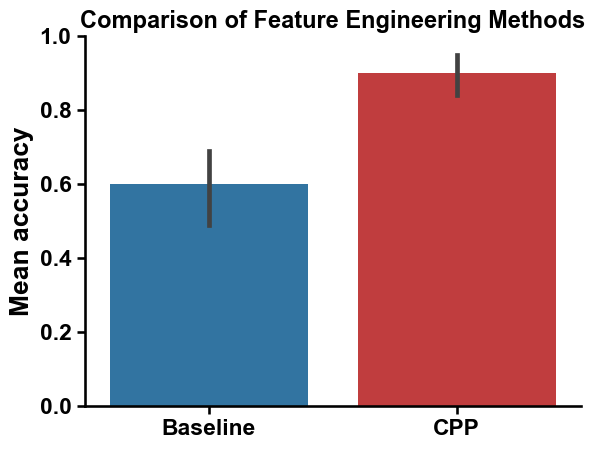

In [26]:
# CPP features with default parts and splits (around 100.000 features)
df_parts = sf.get_df_parts(df_seq=df_seq)
cpp = aa.CPP(df_scales=df_scales, df_parts=df_parts)
df_feat = cpp.run(labels=y)
aa.display_df(df=df_feat.head(10))

X = sf.feature_matrix(df_parts=df_parts, features=df_feat["feature"])
rf = RandomForestClassifier()
cv = cross_val_score(rf, X, y, scoring="accuracy", cv=5) 
print(f"Mean accuracy of {round(np.mean(cv), 2)}")

# Plot comparison of two approaches
aa.plot_settings()
sns.barplot(pd.DataFrame({"Baseline": cv_base, "CPP": cv}), palette=["tab:blue", "tab:red"])
plt.ylabel("Mean accuracy", size=aa.plot_gcfs()+1)
plt.ylim(0, 1)
plt.title("Comparison of Feature Engineering Methods", size=aa.plot_gcfs()-1)
sns.despine()
plt.show()